In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *
import random
seed = 2022
random.seed(seed)

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=16000, max_depth=4):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=max_depth, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

In [17]:
rng = np.random.default_rng(seed)
balances = {}
idx_tr, X_tr, y_tr = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 3
    X_tr_onto, y_tr_onto = make_dataset(onto, fact, 16000, query_feature_length)

    idx_tr += [i]*len(X_tr_onto)
    print(onto_name, '- balance', np.round(np.mean(y_tr_onto), 4))
    balances[onto_name] = np.round(np.mean(y_tr_onto), 4)
    X_tr += X_tr_onto
    y_tr += y_tr_onto
    
data_tr = idx_tr, X_tr, y_tr = jointshuffle(rng, idx_tr, X_tr, y_tr)

wildlife - balance 0.0937
demacare - balance 0.0376
stuff - balance 0.2446
swo - balance 0.2571
ontodt - balance 0.0656
pizza - balance 0.3914


In [ ]:
def adjust_label_distribution(onto, fact, X, y, target_balance=0.1, query_length=3, max_iter=25):

    decay =0.96
    part =0.6
    tolerance = 0.015 if target_balance > 0.125 else 0.0075
    for i in range(max_iter):
        balance = np.mean(y)
        if abs(balance - target_balance) <= tolerance:
            break
        
        if balance > target_balance:
            majority_class = 1
        else:
            majority_class = 0
        
        excess =  int(part * y.count(majority_class))
        if excess == 0:
            continue
        
        indices = list(range(len(y)))
        indices_to_remove = random.sample([i for i, label in enumerate(y) if label == majority_class], excess)
        indices_to_keep = [i for i in indices if i not in indices_to_remove]
        
        X = [X[i] for i in indices_to_keep]
        y = [y[i] for i in indices_to_keep]
        
        num_to_add = len(indices_to_remove)
        if num_to_add > 0:
            X_new, y_new = make_dataset(onto, fact, num_to_add, query_length)
            X.extend(X_new)
            y.extend(y_new)
        part*=decay

    return X, y

In [49]:
idx_vl, X_vl, y_vl = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 15
    X_vl_onto, y_vl_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_vl_onto, y_vl_onto = adjust_label_distribution(onto, fact, X_vl_onto, y_vl_onto, balances[onto_name], query_feature_length)

    idx_vl += [i]*len(X_vl_onto)
    print(onto_name, '- balance', np.round(np.mean(y_vl_onto), 4))
    X_vl += X_vl_onto
    y_vl += y_vl_onto
    
data_vl = idx_vl, X_vl, y_vl = jointshuffle(rng, idx_vl, X_vl, y_vl)

wildlife - balance 0.0983
demacare - balance 0.0387
stuff - balance 0.2463
swo - balance 0.2647
ontodt - balance 0.068
pizza - balance 0.4023


In [51]:
idx_te, X_te, y_te = [], [], []
query_feature_length = 15
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_te_onto, y_te_onto = adjust_label_distribution(onto, fact, X_te_onto, y_te_onto, balances[onto_name], query_feature_length)

    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
data_te = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.0983
demacare - balance 0.0387
stuff - balance 0.2463
swo - balance 0.2647
ontodt - balance 0.068
pizza - balance 0.4023


In [61]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240710T195046/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data_tr, data_vl, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params, identities_weight=0.038, identitity_weight_decay=0.91)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 3001/3000 | loss 1.4039 | val loss 1.4461 | acc 0.6260 | f1 0.3469 | prec 0.2572 | recall 0.5329 | roc auc 0.6323 | pr auc 0.3242 | elapsed 108.10s
train epoch 01/10 | batch 3001/3000 | loss 0.8542 | val loss 0.5132 | acc 0.8197 | f1 0.5523 | prec 0.5140 | recall 0.5967 | roc auc 0.8396 | pr auc 0.6131 | elapsed 302.63s
train epoch 02/10 | batch 3001/3000 | loss 0.4582 | val loss 0.3613 | acc 0.8693 | f1 0.6543 | prec 0.6454 | recall 0.6635 | roc auc 0.9002 | pr auc 0.7283 | elapsed 370.93s
train epoch 03/10 | batch 3001/3000 | loss 0.3434 | val loss 0.3091 | acc 0.8889 | f1 0.6983 | prec 0.7069 | recall 0.6900 | roc auc 0.9225 | pr auc 0.7787 | elapsed 308.26s
train epoch 04/10 | batch 3001/3000 | loss 0.2878 | val loss 0.2839 | acc 0.8963 | f1 0.7195 | prec 0.7253 | recall 0.7139 | roc auc 0.9335 | pr auc 0.8043 | elapsed 238.30s
train epoch 05/10 | batch 3001/3000 | loss 0.2528 | val loss 0.2714 | acc 0.8998 | f1 0.7309 

In [60]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer) original')
T.manual_seed(seed)
transfer_log_orig = train(data_tr, data_vl, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer) original
train epoch 00/10 | batch 3001/3000 | loss 1.2592 | val loss 1.4040 | acc 0.6589 | f1 0.3921 | prec 0.2936 | recall 0.5902 | roc auc 0.6905 | pr auc 0.3587 | elapsed 97.12s
train epoch 01/10 | batch 3001/3000 | loss 0.7061 | val loss 0.4847 | acc 0.8460 | f1 0.6021 | prec 0.5807 | recall 0.6250 | roc auc 0.8511 | pr auc 0.6431 | elapsed 201.60s
train epoch 02/10 | batch 3001/3000 | loss 0.3578 | val loss 0.3781 | acc 0.8779 | f1 0.6601 | prec 0.6863 | recall 0.6358 | roc auc 0.8934 | pr auc 0.7332 | elapsed 217.28s
train epoch 03/10 | batch 3001/3000 | loss 0.2689 | val loss 0.3446 | acc 0.8908 | f1 0.6922 | prec 0.7294 | recall 0.6587 | roc auc 0.9090 | pr auc 0.7678 | elapsed 219.36s
train epoch 04/10 | batch 3001/3000 | loss 0.2279 | val loss 0.3267 | acc 0.8965 | f1 0.7067 | prec 0.7490 | recall 0.6689 | roc auc 0.9175 | pr auc 0.7849 | elapsed 227.88s
train epoch 05/10 | batch 3001/3000 | loss 0.2030 | val loss 0.3178 | acc 0.9011 | f1 0.71

local/out/exp/20240712T142244
------
Frozen pre-trained reasoner head original
train time 2060.790914773941
           mean     std   micro
acc      0.9090  0.0661  0.9090
prec     0.8241  0.1031  0.7893
recall   0.6573  0.0741  0.6981
f1       0.7261  0.0560  0.7409
auc_roc  0.9160  0.0274  0.9326
auc_pr   0.7880  0.0678  0.8188
------
Frozen pre-trained reasoner head
train time 2093.9915103912354
           mean     std   micro
acc      0.9099  0.0653  0.9099
prec     0.7654  0.1094  0.7536
recall   0.7321  0.0705  0.7675
f1       0.7449  0.0730  0.7605
auc_roc  0.9295  0.0326  0.9483
auc_pr   0.8137  0.0725  0.8437


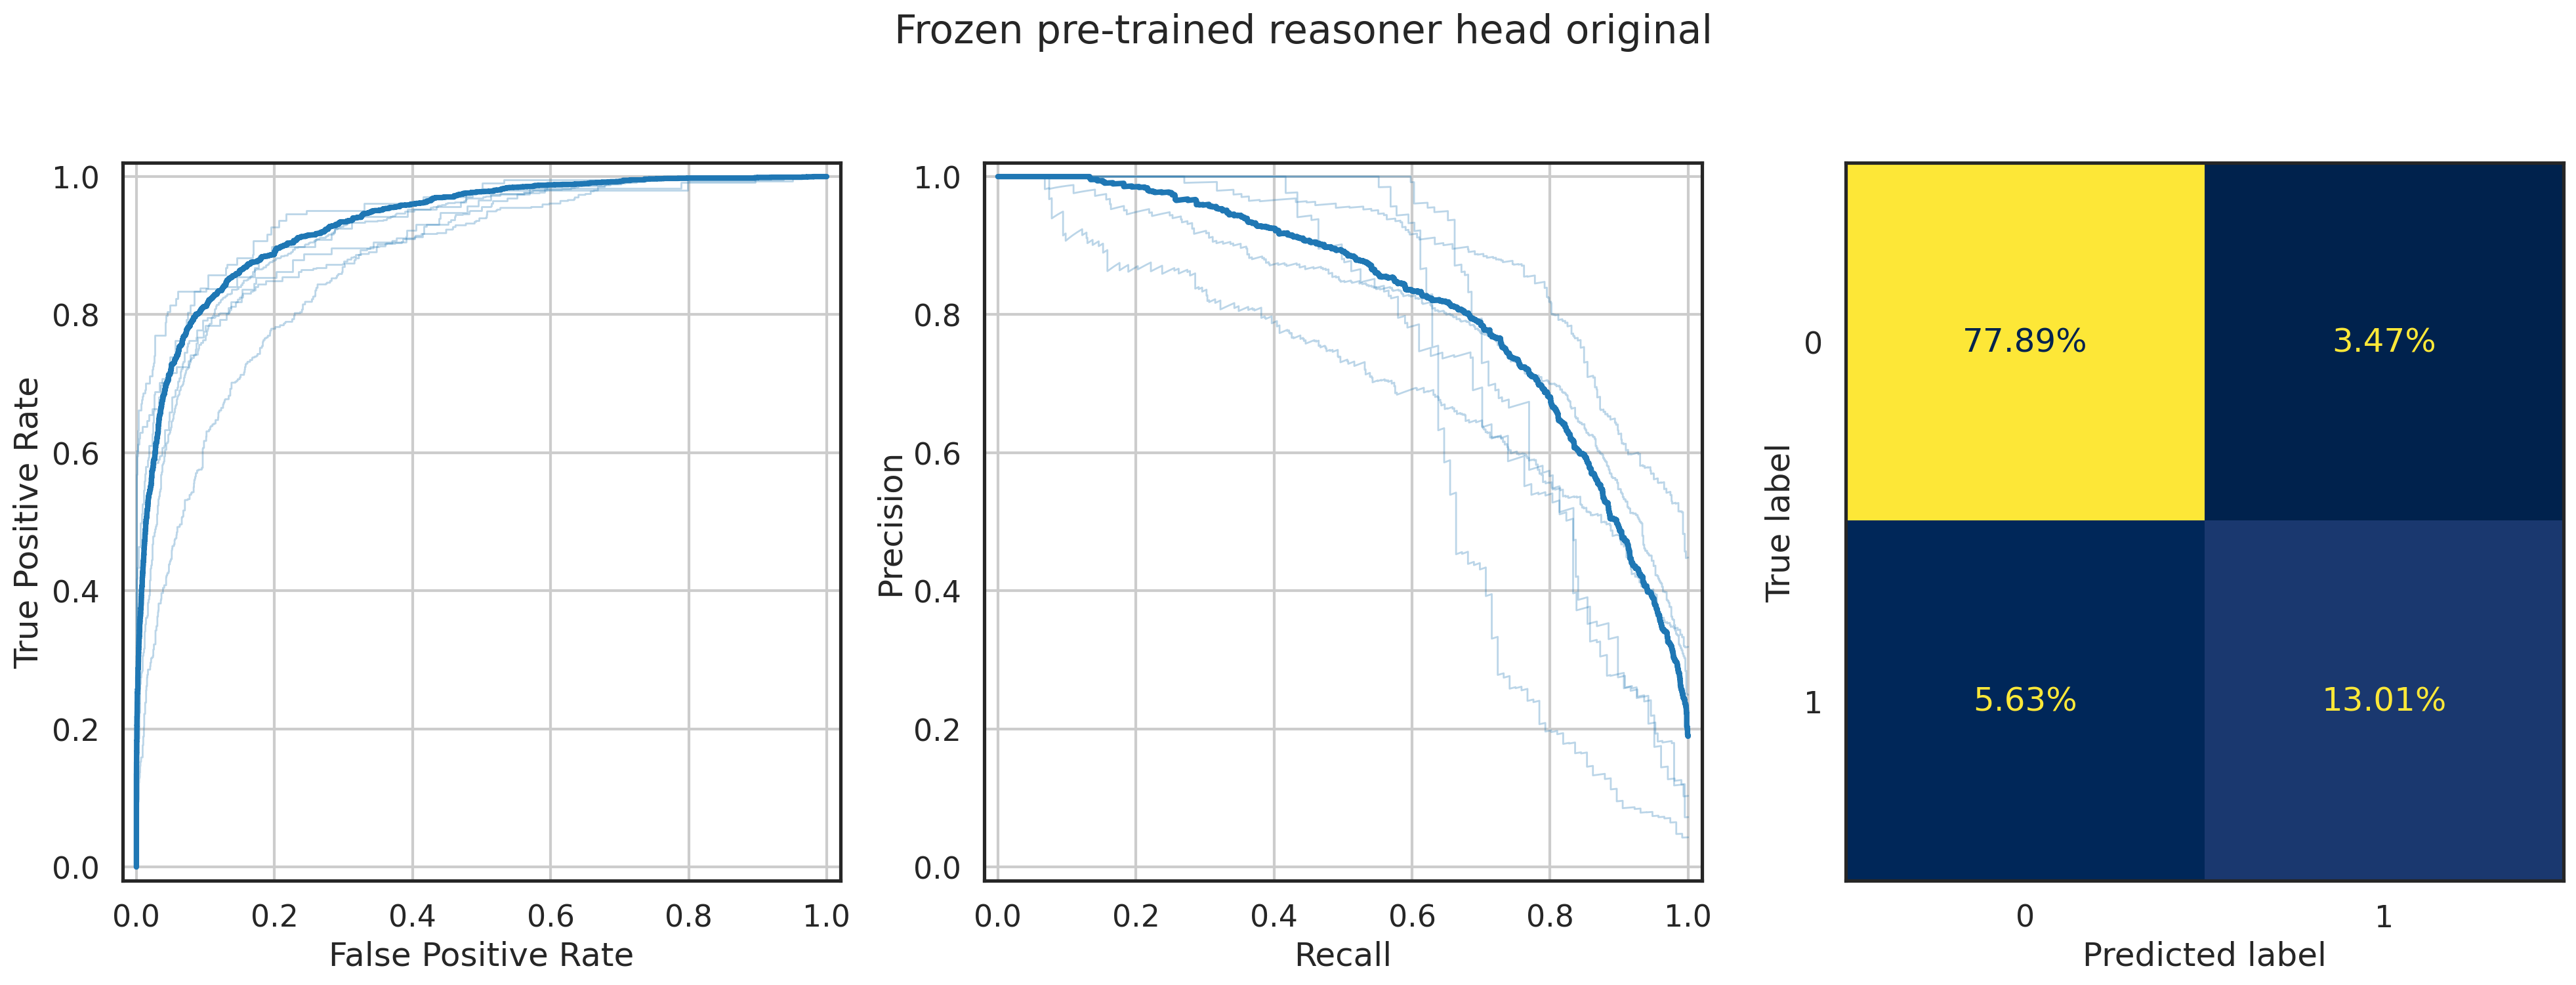

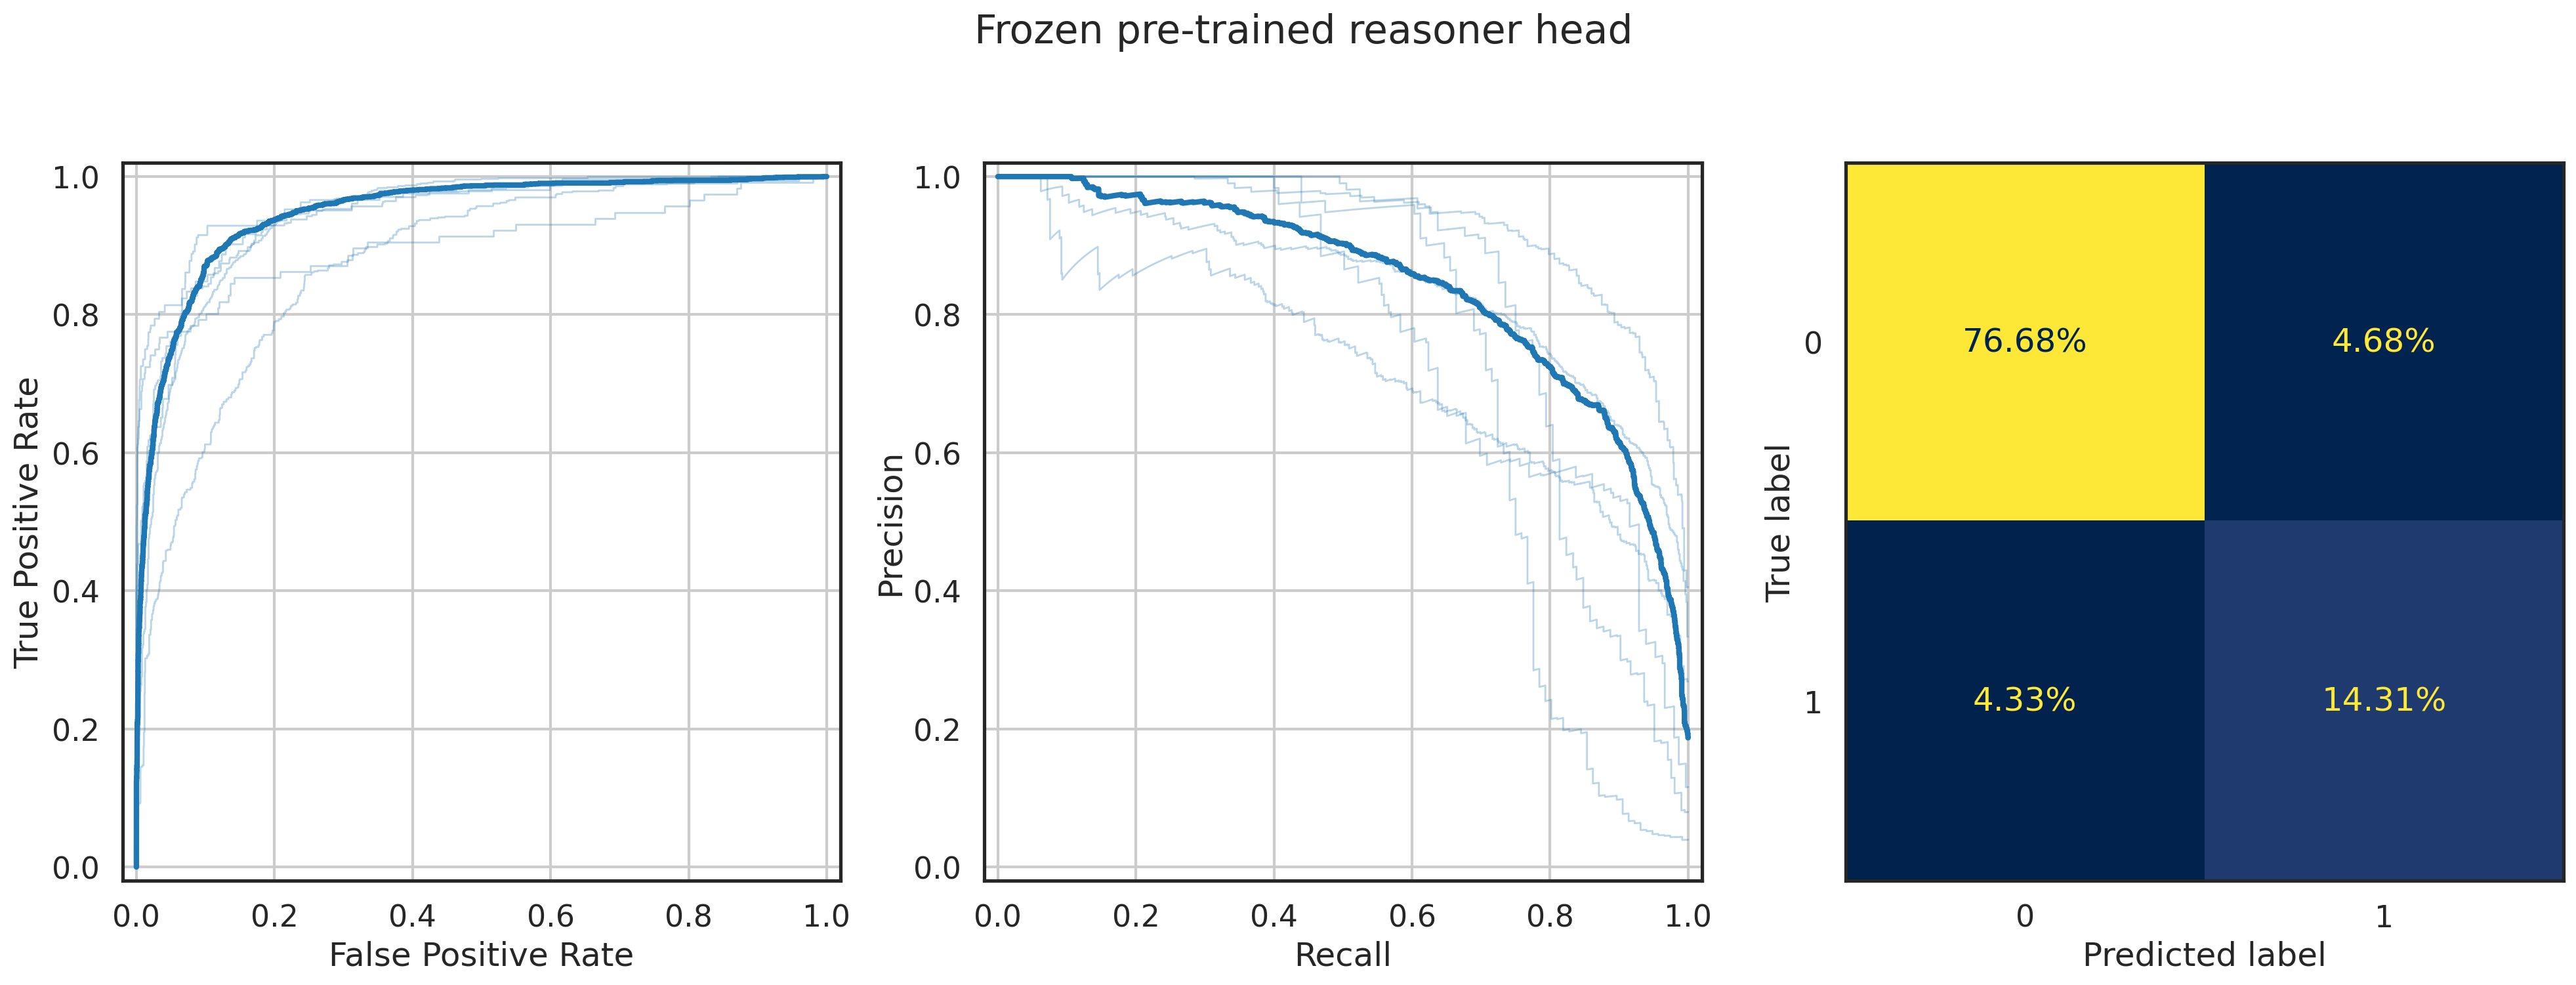

In [62]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [15]:
base = 'local/out/exp/' + 'exp5_frozen_new'
mkdirp(base)
T.save(transfer_r_embs, base+'/emb_mod_layer.pt')
T.save(transfer_r_orig_embs, base+'/emb_orig_layer.pt')

In [35]:
a = T.load(base+'/emb_orig_layer.pt')

In [42]:
b = T.load(base+'/emb_mod_layer.pt')

In [17]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

NameError: name 'df' is not defined

In [69]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rec': np.arange(len(X_te_2))[błędne_predykcje],
    'True': y_te_2[błędne_predykcje],
    'Pred': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'F{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)



/tmp/ipykernel_8029/1003111826.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te_2 = np.array(X_te)


In [71]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:0.2f}'.format):  # more options can be specified also
    print(wyniki)

        Rec  True  Pred F0                                                 F1  \
0         2     1  0.09  0  (4, (7, 24, (4, (4, (3, 165), (3, (7, 38, (3, ...   
1        44     0  0.82  0  (4, (3, (4, (3, (4, -2, 45)), (4, (3, (4, (3, ...   
2        45     0  0.85  0  (4, (4, (3, (4, (4, 157, 0), (3, 25))), (3, 12...   
3        97     1  0.01  0  (7, 20, (3, (7, 41, (4, (3, (7, 39, 128)), (3,...   
4       111     1  0.00  0  (4, (3, (7, 42, (4, (4, (3, (4, (7, 48, (3, (7...   
5       155     1  0.02  0  (7, 24, (3, (4, (3, (7, 49, (3, 60))), (4, (3,...   
6       160     0  0.96  0                  (4, 249, (4, (3, 147), (3, 150)))   
7       161     1  0.01  0  (4, (7, 27, (4, (4, (7, 30, (3, (4, (3, 244), ...   
8       253     1  0.05  0  (4, (4, (4, 27, (4, (4, 4, (3, (7, 36, (7, 44,...   
9       280     1  0.07  0  (7, 43, (7, 51, (4, (4, (4, (4, 249, (3, (7, 3...   
10      319     0  0.60  0  (4, (4, (3, (4, (7, 0, 119), (7, 25, (7, 41, (...   
11      321     1  0.00  0  

In [61]:
T.sigmoid( transfer_r_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([1.5229e-06], grad_fn=<SigmoidBackward0>)

In [62]:
T.sigmoid(transfer_r_orig_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.0002], grad_fn=<SigmoidBackward0>)

In [17]:
T.set_printoptions(precision=4)

In [18]:
import random

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_head.and_nn(im_mod(input, input)))

tensor([-0.1125,  0.0322,  0.1424, -0.1234, -0.0400, -0.1138, -0.1118, -0.0830,
         0.2008,  0.2245], grad_fn=<SelectBackward0>)
tensor([ 0.0384, -0.1315,  0.0648, -0.1071,  0.0711, -0.1677, -0.1073, -0.1429,
         0.0586,  0.0772], grad_fn=<AddBackward0>)


tensor(0.0117, grad_fn=<MseLossBackward0>)

In [19]:
import random

encoder = transfer_r_orig_embs[int(np.round(random.random() * (len(transfer_r_orig_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_orig_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_orig_head.and_nn(im_mod(input, input)))

tensor([ 0.2098,  0.0210, -0.1154, -0.0016,  0.0497,  0.0543,  0.1388,  0.1556,
        -0.1427, -0.0338], grad_fn=<SelectBackward0>)
tensor([ 0.0510,  0.0924, -0.1627,  0.1153, -0.0297,  0.1430,  0.1297,  0.0747,
        -0.1075, -0.1178], grad_fn=<AddBackward0>)


tensor(0.0772, grad_fn=<L1LossBackward0>)

In [26]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
print(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)), transfer_r_head.bot_concept[0]))

tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.3106,  0.1712,  0.0559, -0.2981,  0.3513, -0.0701,  0.0724,  0.0947,
        -0.2007, -0.1027], grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<L1LossBackward0>)


In [42]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)), input))

tensor([ 0.0473, -0.0081, -0.0314,  0.0069, -0.0618,  0.0093,  0.0473,  0.0647,
        -0.0276,  0.0595], grad_fn=<SelectBackward0>)
tensor([ 0.0052, -0.0398, -0.0376,  0.0306, -0.0041, -0.0402,  0.0367,  0.0048,
        -0.0033,  0.0432], grad_fn=<AddBackward0>)
tensor(0.0322, grad_fn=<L1LossBackward0>)


In [43]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
output = transfer_r_head.and_nn(im_mod(transfer_r_head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.1392, -0.0101, -0.0039, -0.1624,  0.1431, -0.1626, -0.1063, -0.0458,
        -0.0641,  0.0290], grad_fn=<AddBackward0>)
tensor(0.1451, grad_fn=<L1LossBackward0>)


In [45]:
print(transfer_r_head.bot_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.top_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.bot_concept[0], output))

tensor([ 0.2911,  0.1877,  0.0530, -0.2795,  0.3472, -0.0709,  0.0837,  0.0983,
        -0.2104, -0.1041], grad_fn=<SelectBackward0>)
tensor([ 0.2936,  0.2399,  0.0531, -0.2797,  0.3856, -0.0701,  0.0794,  0.1559,
        -0.2557, -0.1044], grad_fn=<SqueezeBackward3>)
tensor(0.0202, grad_fn=<L1LossBackward0>)


In [46]:
print(transfer_r_head.top_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.bot_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.top_concept[0], output))

tensor([-0.1209, -0.2776, -0.0367,  0.4054,  0.0284,  0.1562,  0.7496,  0.0836,
        -0.1136,  0.3484], grad_fn=<SelectBackward0>)
tensor([-0.1207, -0.2118, -0.0288,  0.4027,  0.0287,  0.1318,  0.6266,  0.0840,
        -0.0738,  0.3387], grad_fn=<SqueezeBackward3>)
tensor(0.0274, grad_fn=<L1LossBackward0>)


In [28]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))))
print(transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))), transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.0896,  0.0893,  0.1495, -0.1570,  0.1763, -0.0506, -0.0373, -0.0389,
        -0.0818, -0.0858], grad_fn=<AddBackward0>)
tensor([ 0.1033,  0.0707,  0.1435, -0.1582,  0.1680, -0.0505, -0.0436, -0.0186,
        -0.0715, -0.0744], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [29]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, input3)))
print(transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

tensor([ 0.0850,  0.0844,  0.1542, -0.1388,  0.1610, -0.0516, -0.0426, -0.0422,
        -0.0735, -0.0799], grad_fn=<AddBackward0>)
tensor([ 0.0774,  0.0776,  0.1453, -0.1347,  0.1567, -0.0506, -0.0467, -0.0254,
        -0.0781, -0.0657], grad_fn=<AddBackward0>)


tensor(7.4109e-05, grad_fn=<MseLossBackward0>)

In [30]:
print(input1)
print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

F.mse_loss(input1, transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

tensor([-0.1377,  0.1033,  0.2035, -0.0095,  0.0677, -0.0641, -0.1233, -0.1963,
        -0.0341, -0.1171], grad_fn=<SelectBackward0>)
tensor([-0.1016,  0.0434,  0.1809, -0.0038,  0.0586, -0.0193, -0.0947, -0.1767,
        -0.0166, -0.0567], grad_fn=<AddBackward0>)


tensor(0.0013, grad_fn=<MseLossBackward0>)